In [1]:
import os
import gc
import xesmf
import logging
import warnings
import numpy as np
import xarray as xr
from datetime import datetime
import proplot as pplt

warnings.filterwarnings('ignore')

/global/homes/s/sferrett/.conda/envs/monsoon-sr/lib/python3.10/site-packages/proplot/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


In [2]:
FILEDIR  = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/raw'

In [3]:
def get_data(filename,filedir=FILEDIR):
    filepath = os.path.join(filedir,filename)
    da = xr.open_dataarray(filepath,engine='h5netcdf')
    if 'lev' in da.dims:
        if not da.lev.diff('lev').all()>0:
            da = da.reindex(lev=sorted(da.lev))
            logger.info(f'   Levels for {filename} were reordered')
    return da

def get_p_array(da):
    p = da.lev.expand_dims({'time':da.time,'lat':da.lat,'lon':da.lon}).transpose('lev','time','lat','lon')
    return p

In [4]:
pr = get_data('IMERG_V06_precipitation_rate.nc')
ps = get_data('ERA5_surface_pressure.nc')
t  = get_data('ERA5_air_temperature.nc')
q  = get_data('ERA5_specific_humidity.nc')
p  = get_p_array(q)

## Precipitation

In [5]:
def regrid_and_resample_mean(da,gridtarget,frequency='h'):
    regridder = xesmf.Regridder(da,gridtarget,method='bilinear')
    da = regridder(da,keep_attrs=True)
    da.coords['time'] = da.time.dt.floor(frequency) 
    da = da.groupby('time').mean()
    return da

def regrid_and_resample_first(da,gridtarget,frequency='h'):
    regridder = xesmf.Regridder(da,gridtarget,method='bilinear')
    da = regridder(da,keep_attrs=True)
    da.coords['time'] = da.time.dt.floor(frequency) 
    da = da.groupby('time').first()
    return da

In [6]:
targetgrid = ps.isel(time=0)
prsubset   = pr.isel(time=slice(0,48))

In [7]:
resultmean  = regrid_and_resample_mean(prsubset,targetgrid,frequency='h')
resultfirst = regrid_and_resample_first(prsubset,targetgrid,frequency='h')

timepointmean  = resultmean.sel(lat=10,lon=78) 
timepointfirst = resultfirst.sel(lat=10,lon=78)

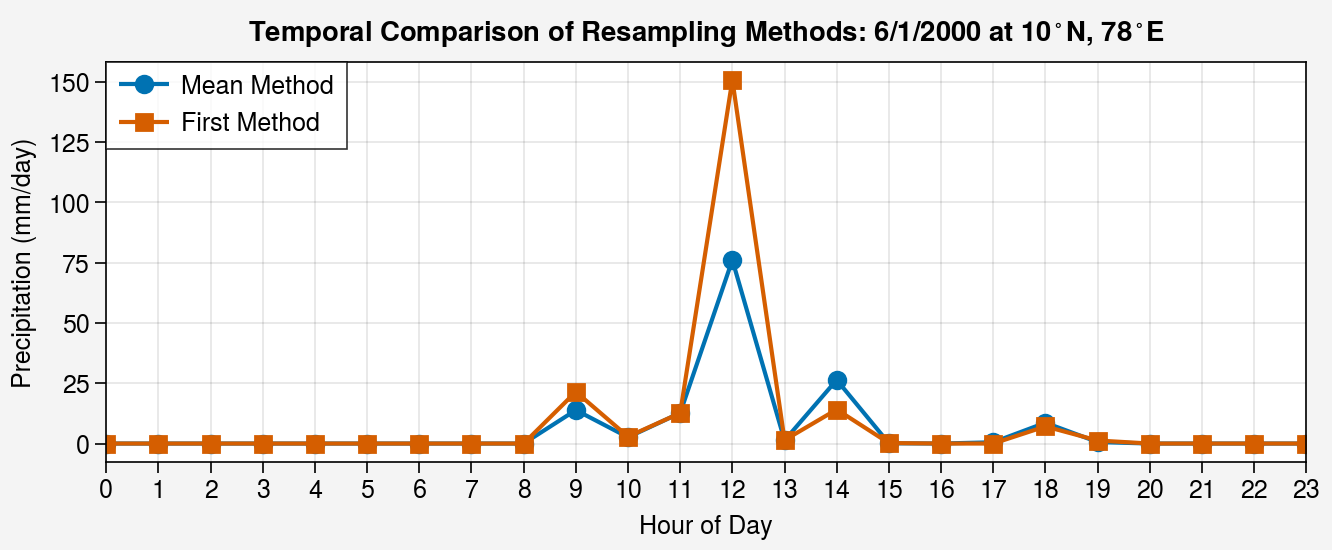

In [8]:
fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=6,refheight=2)
ax.format(suptitle='Temporal Comparison of Resampling Methods: 6/1/2000 at 10$^\circ$N, 78$^\circ$E',
          xlabel='Hour of Day',xticks=1,xminorticks='none',
          ylabel='Precipitation (mm/day)',yminorticks='none')
ax.plot(timepointmean.time.dt.hour,timepointmean,label='Mean Method',marker='o')
ax.plot(timepointfirst.time.dt.hour,timepointfirst,label='First Method',marker='s')
ax.legend(loc='ul',ncols=1)
pplt.show()

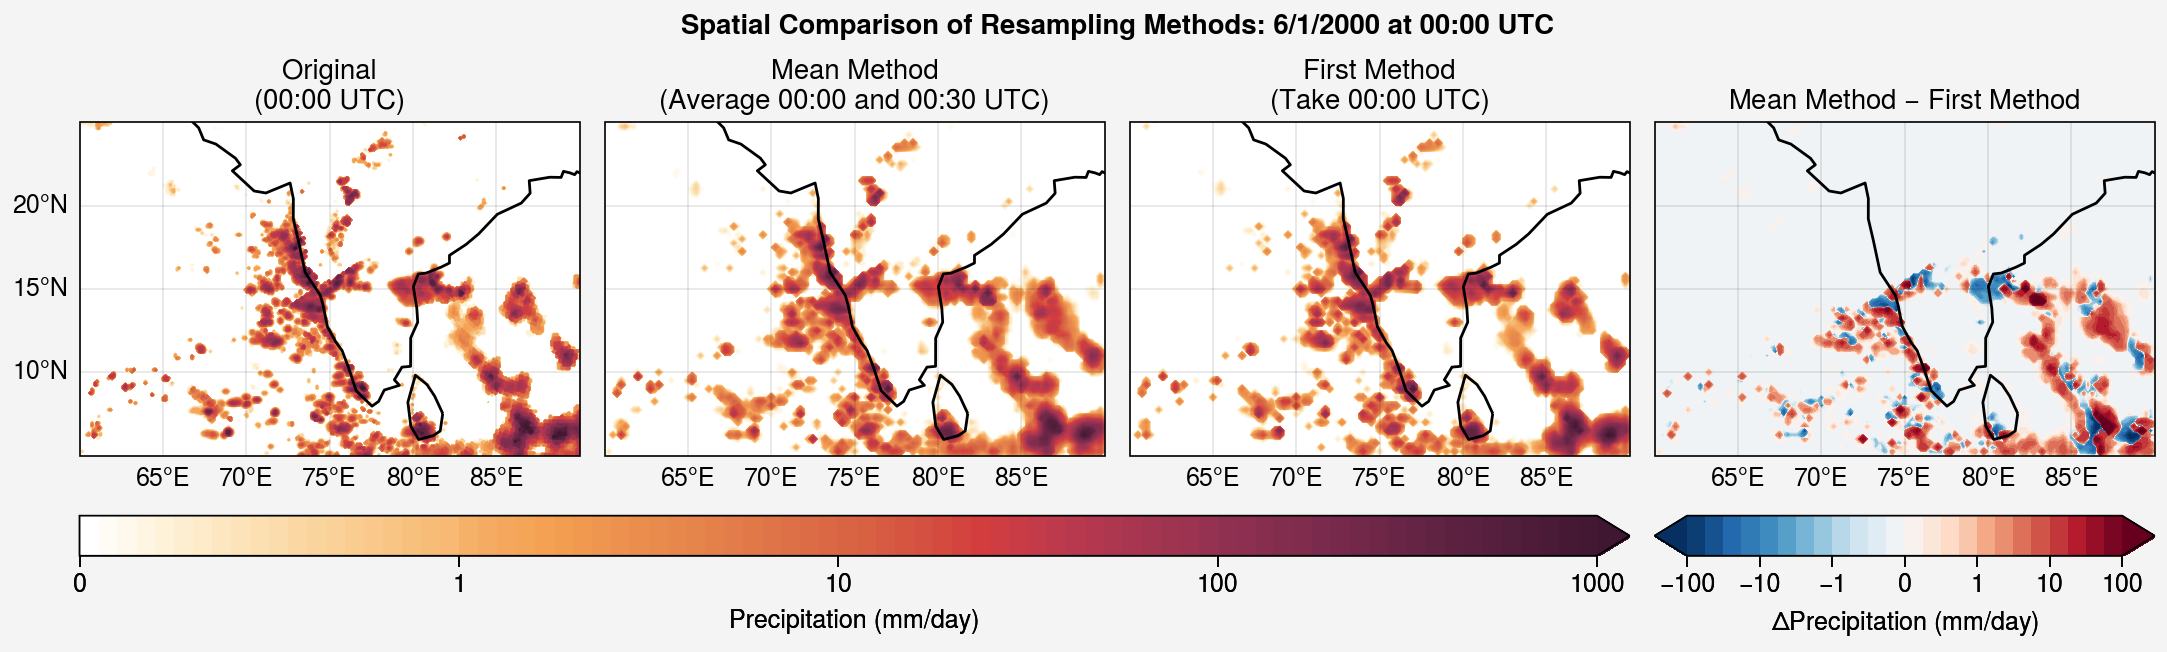

In [9]:
fig,axs = pplt.subplots(nrows=1,ncols=4,proj='cyl')
axs.format(coast=True,coastlinewidth=1,latlim=(5,25),latlines=[10,15,20],lonlim=(60,90),lonlines=5,lonlabels=True,
           suptitle='Spatial Comparison of Resampling Methods: 6/1/2000 at 00:00 UTC')
axs[0].format(latlabels=True,title='Original\n(00:00 UTC)')
axs[1].format(title='Mean Method\n(Average 00:00 and 00:30 UTC)')
axs[2].format(title='First Method\n(Take 00:00 UTC)')
axs[3].format(title='Mean Method $-$ First Method')
axs[0].contourf(prsubset.isel(time=0),norm='symlog',vmin=0,vmax=1000,levels=100,extend='max')
axs[1].contourf(resultmean.isel(time=0),norm='symlog',vmin=0,vmax=1000,levels=100,extend='max')
mesh = axs[2].contourf(resultfirst.isel(time=0),norm='symlog',vmin=0,vmax=1000,levels=100,extend='max')
fig.colorbar(mesh,loc='b',cols=(1,3),ticks=[0,1,10,100,1000],title='Precipitation (mm/day)')
mesh = axs[3].contourf((resultmean-resultfirst).isel(time=0),norm='symlog',vmin=-100,vmax=100,levels=32,extend='both')
fig.colorbar(mesh,loc='b',cols=4,ticks=[-100,-10,-1,0,1,10,100],title='$\Delta$Precipitation (mm/day)')
pplt.show()

## Filtering

In [10]:
def calc_es(t):
    tc  = t-273.15
    esw = np.exp(34.494-(4924.99/(tc+237.1)))/((tc+105.)**1.57)
    esi = np.exp(43.494-(6545.8/(tc+278.)))/((tc+868.)**2.)
    es  = np.where(tc>0.,esw,esi) 
    es  = es/100.
    return es

def calc_qs(p,t):
    rv = 461.50   
    rd = 287.04    
    es = calc_es(t) 
    epsilon = rd/rv
    qs = (epsilon*es)/(p-es*(1.-epsilon))
    return qs

def calc_thetae(p,t,q=None,ps=None):
    if q is None:
        q = calc_qs(p,t)
    if ps is not None:
        psclamped = xr.where(ps>1000.,1000.,ps)
        t = t.interp(lev=psclamped)
        q = q.interp(lev=psclamped)
        p = psclamped
    p0 = 1000.  
    rv = 461.5  
    rd = 287.04
    epsilon = rd/rv
    r  = q/(1.-q) 
    e  = (p*r)/(epsilon+r)
    tl = 2840./(3.5*np.log(t)-np.log(e)-4.805)+55.
    thetae = t*(p0/p)**(0.2854*(1.-0.28*r))*np.exp((3.376/tl-0.00254)*1000.*r*(1.+0.81*r))
    return thetae    

def filter_above_surface(da,ps):
    da = xr.where(da.lev<=ps,da,np.nan)
    return da

def calc_layer_average_1(da,upperbound,lowerbound):
    def get_adjacent_pressure(pref,levs,side,direction):
        if direction=='above':
            return xr.apply_ufunc(lambda x:levs[np.maximum(np.searchsorted(levs,x,side=side)-1,0)],pref)
        elif direction=='below':
            return xr.apply_ufunc(lambda x:levs[np.minimum(np.searchsorted(levs,x,side=side),len(levs)-1)],pref)
        else:
            raise ValueError("Direction must be either 'above' or 'below'")
    def integrate_partial_layer(pref,pabove,pbelow,daabove,dabelow,bound):
        dp = pbelow-pabove
        dp = xr.where(dp==0,1e-8,dp)
        if bound=='upper':
            correction = -daabove/2*dp*(pref<pabove.min())
            integral   = (pref-pabove)*daabove+(dabelow-daabove)*(pref-pabove)**2/(2*dp)+correction
            return integral
        elif bound=='lower':
            correction = -dabelow/2*dp*(pref>pbelow.max())
            integral   = (pbelow-pref)*daabove+(dabelow-daabove)*dp*(1-((pref-pabove)/dp)**2)/2+correction
            return integral
        else:
            raise ValueError("Bound must be either 'upper' or 'lower'")
    da,upperbound,lowerbound = da.load(),upperbound.load(),lowerbound.load()
    paboveupper   = get_adjacent_pressure(upperbound,np.array(da.lev),'right','above')
    pbelowupper   = get_adjacent_pressure(upperbound,np.array(da.lev),'right','below')
    upperintegral = integrate_partial_layer(upperbound,paboveupper,pbelowupper,da.sel(lev=paboveupper),da.sel(lev=pbelowupper),bound='upper')
    pabovelower   = get_adjacent_pressure(lowerbound,np.array(da.lev),'left','above')
    pbelowlower   = get_adjacent_pressure(lowerbound,np.array(da.lev),'left','below')
    lowerintegral = integrate_partial_layer(lowerbound,pabovelower,pbelowlower,da.sel(lev=pabovelower),da.sel(lev=pbelowlower),bound='lower')
    innerintegral = (da*(da.lev<=upperbound)*(da.lev>=lowerbound)).integrate('lev')
    layeraverage  = (upperintegral+innerintegral-lowerintegral)/(upperbound-lowerbound)
    return layeraverage

def calc_layer_average_2(da,a,b):
    def get_level_above(ptarget,levels,side):
        searchidx = np.searchsorted(levels,ptarget,side=side)
        levabove  = levels[np.maximum(searchidx-1,0)]
        return levabove
    def get_level_below(ptarget,levels,side):
        searchidx = np.searchsorted(levels,ptarget,side=side)
        levbelow  = levels[np.minimum(searchidx,len(levels)-1)]
        return levbelow
    da = da.load()
    a  = a.load()
    b  = b.load()
    levabove = xr.apply_ufunc(get_level_above,a,kwargs={'levels':np.array(da.lev),'side':'right'})
    levbelow = xr.apply_ufunc(get_level_below,a,kwargs={'levels':np.array(da.lev),'side':'right'})
    valueabove = da.sel(lev=levabove)
    valuebelow = da.sel(lev=levbelow)
    correction = -valueabove/2*(levbelow-levabove)*(a<da.lev[-1])
    levbelow   = levbelow+(levbelow==levabove)
    lowerintegral = (a-levabove)*valueabove+(valuebelow-valueabove)*(a-levabove)**2/(levbelow-levabove)/2+correction
    innerintegral = (da*(da.lev<=a)*(da.lev>=b)).fillna(0).integrate('lev')
    levabove = xr.apply_ufunc(get_level_above,b,kwargs={'levels':np.array(da.lev),'side':'left'})
    levbelow = xr.apply_ufunc(get_level_below,b,kwargs={'levels':np.array(da.lev),'side':'left'})
    valueabove = da.sel(lev=levabove)
    valuebelow = da.sel(lev=levbelow)
    correction = -valuebelow/2*(levbelow-levabove)*(b>da.lev[0])
    levabove   = levabove-(levbelow==levabove)
    upperintegral = (levbelow-b)*valueabove+(valuebelow-valueabove)*(levbelow-levabove)*(1-((b-levabove)/(levbelow-levabove))**2)/2+correction
    layeraverage  = (lowerintegral+innerintegral+upperintegral)/(a-b)
    return layeraverage

def calc_layer_average_2_fil(da,a,b):
    def get_level_above(ptarget,levels,side):
        searchidx = np.searchsorted(levels,ptarget,side=side)
        levabove  = levels[np.maximum(searchidx-1,0)]
        return levabove
    def get_level_below(ptarget,levels,side):
        searchidx = np.searchsorted(levels,ptarget,side=side)
        levbelow  = levels[np.minimum(searchidx,len(levels)-1)]
        return levbelow
    da = da.load()
    a  = a.load()
    b  = b.load()
    levabove = xr.apply_ufunc(get_level_above,a,kwargs={'levels':np.array(da.lev),'side':'right'})
    levbelow = xr.apply_ufunc(get_level_below,a,kwargs={'levels':np.array(da.lev),'side':'right'})
    valueabove = da.sel(lev=levabove)
    valuebelow = da.sel(lev=levbelow)
    correction = -valueabove/2*(levbelow-levabove)*(a<da.lev[-1])
    levbelow   = levbelow+(levbelow==levabove)
    lowerintegral = (a-levabove)*valueabove+(valuebelow-valueabove)*(a-levabove)**2/(levbelow-levabove)/2+correction
    lowerintegral = lowerintegral.fillna(0)
    innerintegral = (da*(da.lev<=a)*(da.lev>=b)).fillna(0).integrate('lev')
    levabove = xr.apply_ufunc(get_level_above,b,kwargs={'levels':np.array(da.lev),'side':'left'})
    levbelow = xr.apply_ufunc(get_level_below,b,kwargs={'levels':np.array(da.lev),'side':'left'})
    valueabove = da.sel(lev=levabove)
    valuebelow = da.sel(lev=levbelow)
    correction = -valuebelow/2*(levbelow-levabove)*(b>da.lev[0])
    levabove   = levabove-(levbelow==levabove)
    upperintegral = (levbelow-b)*valueabove+(valuebelow-valueabove)*(levbelow-levabove)*(1-((b-levabove)/(levbelow-levabove))**2)/2+correction
    upperintegral = upperintegral.fillna(0)  
    layeraverage  = (lowerintegral+innerintegral+upperintegral)/(a-b)
    return layeraverage

In [11]:
psubset  = p.isel(time=0).sel(lat=10,lon=78)
tsubset  = t.isel(time=0).sel(lat=10,lon=78)
qsubset  = q.isel(time=0).sel(lat=10,lon=78)
pssubset = ps.isel(time=0).sel(lat=10,lon=78)

thetae    = calc_thetae(psubset,tsubset,qsubset)
thetaefil = filter_above_surface(thetae,pssubset)

pbltop  = pssubset-100.
lfttop  = xr.full_like(pssubset,500.) 

thetaeb1 = calc_layer_average_1(thetae,pssubset,pbltop)*np.sqrt(-1+2*(pssubset>lfttop))
thetael1 = calc_layer_average_1(thetae,pbltop,lfttop)
thetaeb2 = calc_layer_average_2(thetae,pssubset,pbltop)*np.sqrt(-1+2*(pssubset>lfttop))
thetael2 = calc_layer_average_2(thetae,pbltop,lfttop)
thetaeb2fil = calc_layer_average_2_fil(thetaefil,pssubset,pbltop)*np.sqrt(-1+2*(pssubset>lfttop))
thetael2fil = calc_layer_average_2_fil(thetaefil,pbltop,lfttop)

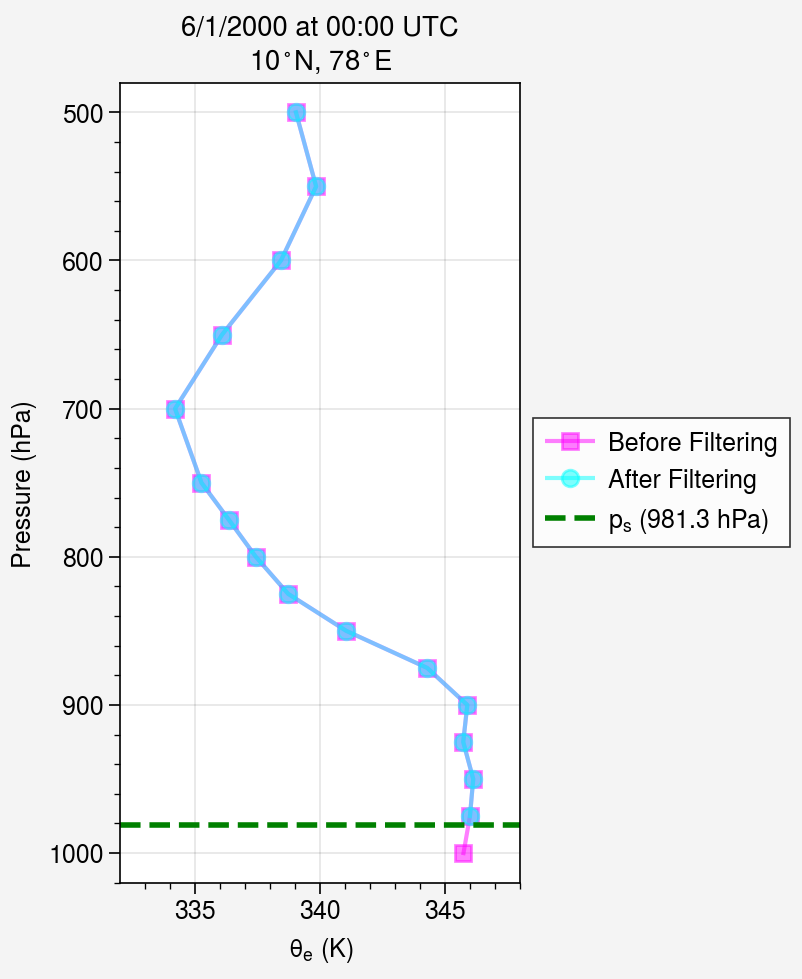

In [78]:
fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2,refheight=4)
ax.format(title='6/1/2000 at 00:00 UTC\n10$^\circ$N, 78$^\circ$E',
          xlabel=r'$\theta_e$ (K)',xlim=(332,348),
          ylabel='Pressure (hPa)',ylim=(1020,480))
ax.plot(thetae,thetae.lev,'s-',label='Before Filtering',color='magenta',markersize=6,alpha=0.5)
ax.plot(thetaefil,thetae.lev,'o-',label='After Filtering',color='cyan',markersize=6,alpha=0.5)
ax.axhline(y=pssubset.values,color='green',linestyle='--',linewidth=2,label=f'$p_s$ ({pssubset.values:.1f} hPa)')
ax.legend(loc='r',ncols=1)
pplt.show()

In [ ]:
fig,ax = pplt.subplots(nrows=1,ncols=1)
ax.format(title='\n6/1/2000 at 00:00 UTC\n10$^\circ$N, 78$^\circ$E',xlabel=r'$\theta_e$ (K)',
          ylim=(1,2),yticks=[1.25,1.75],yticklabels=[r'$\theta_{eB}$',r'$\theta_{eL}$'],yminorticks='none')
ax.scatter(thetaeb1,1.25,marker='o',color='r',alpha=0.5,label='Incorrect Averaging')
ax.scatter(thetaeb2,1.25,marker='s',color='k',alpha=0.5,label='Correct Averaging')
ax.scatter(thetael1,1.75,marker='o',color='r',alpha=0.5)
ax.scatter(thetael2,1.75,marker='s',color='k',alpha=0.5)
ax.legend(loc='ul',ncols=1)
pplt.show()

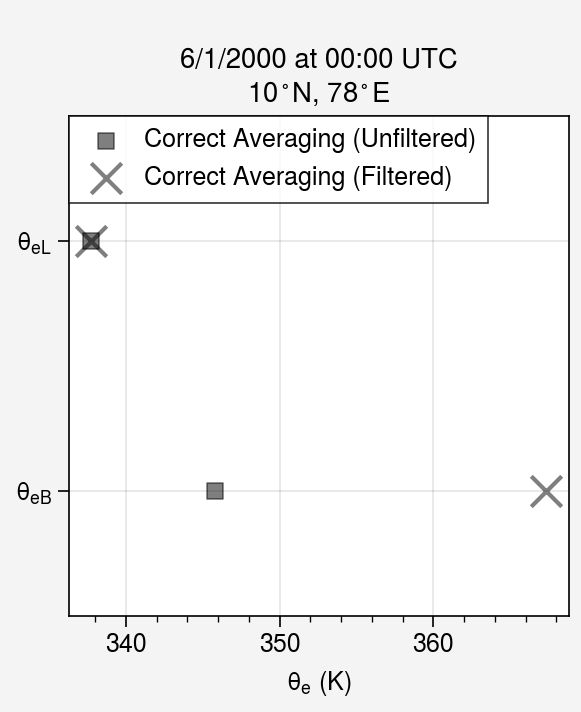

In [81]:
fig,ax = pplt.subplots(nrows=1,ncols=1)
ax.format(title='\n6/1/2000 at 00:00 UTC\n10$^\circ$N, 78$^\circ$E',xlabel=r'$\theta_e$ (K)',
          ylim=(1,2),yticks=[1.25,1.75],yticklabels=[r'$\theta_{eB}$',r'$\theta_{eL}$'],yminorticks='none')
ax.scatter(thetaeb2,1.25,marker='s',color='k',alpha=0.5,label='Correct Averaging (Unfiltered)')
ax.scatter(thetaeb2fil,1.25,marker='x',color='k',alpha=0.5,markersize=120,label='Correct Averaging (Filtered)')
ax.scatter(thetael2,1.75,marker='s',color='k',alpha=0.5)
ax.scatter(thetael2fil,1.75,marker='x',color='k',alpha=0.5,markersize=120)
ax.legend(loc='ul',ncols=1)
pplt.show()